# Unified Evidential Training Example

To add training functionality to the probly package, we want to add a Unified Evidential Training function, that enables evidential models to be easily trained.

This notebook demonstrates how a Unified Evidential Training Function works.
It uses the `MNIST-dataset` and the `EvidentialCELoss` loss-function, as introduced by _Sensoy et al. (2018)_.
The function `unified_evidential_train()` simulates, how the routine is going to look later on.

This notebook can be divided into 5 sections:

1. Imports & Setup
2. Data Preparation
3. Model Definition
4. Unified Evidential Training Function
5. Starting Training Loop

### 1. Imports & Setup
- **torch** → building neural networks
- **torchvision** → used to convert images to tensors and normalize them
- **losses** → pre-defined loss-functions
- **models** → pre-defined models
- **unified_evidential_train_class** → our pre-defined unified-evidential-training function

This imports everything your Unified Evidential Training Function will also depend on:
datasets, losses, and the PyTorch core tools.
Right now we do it manually but the unified function will handle this internally later on.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import probly.layers.evidential.torch as models
import probly.losses.evidential.torch as losses
from probly.train.evidential.common import unified_evidential_train

### 2. Data Preparation
This simulates how the function will handle datasets. It'll prepare them by e.g. converting images to tensors and normalizing pixels.

In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ],
)

# In-distribution data
train_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=True,
    download=True,
    transform=transform,
)

test_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

print("MNIST loaded (ID).")

# Out-of-distribution data
ood_data = torchvision.datasets.FashionMNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

ood_loader = DataLoader(ood_data, batch_size=256, shuffle=False)

print(f"Loaded datasets with {len(train_data)} samples.")

MNIST loaded (ID).
Loaded datasets with 60000 samples.


### 3. Model Definition
This is an example of a small Convolutional Neural Network (CNN), that produces evidence values instead of softmax probabilities. Later on we can also use models from `probly.layers` if we want to.
Our unified function will be able to train such a model with the corresponding evidential loss.

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:  # noqa: D107
        super().__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # noqa: D102
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return F.softplus(self.fc2(x))  # use of softplus so that our output is always positive


model = SimpleCNN()

### 4. Unified Evidential Training Function
In this part, we create the heart of our notebook...the Unified Evidential Train Function.
Its takes a model and a bunch of other parameters in, that the user can costumize before running.
After starting, it creates a training loop for evidential deep learning in PyTorch based on our given parameters (e.g. model, loss-function, epochs...).

In [ ]:
def unified_evidential_train_showcase(model, dataloader, loss_fn, epochs=5, lr=1e-3, device="cpu") -> None:  # noqa: ANN001
    """Demonstration of a unified evidential training function."""
    model = model.to(device)  # moves the model to the correct device (GPU or CPU)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # repeats the training function for a defined number of epochs
    for epoch in range(epochs):
        model.train()  # call of train important for models like dropout
        total_loss = 0.0  # track total_loss to calculate average loss per epoch

        for x, y in dataloader:
            # handle both cases: distributions (CIFAR10H original) or integer labels (fallback)
            x = x.to(device)  # noqa: PLW2901

            y = torch.tensor(y, device=device) if not torch.is_tensor(y) else y.to(device)  # noqa: PLW2901

            optimizer.zero_grad()  # clears old gradients
            outputs = model(x)  # computes model-outputs
            loss = loss_fn(outputs, y)  # calculate the evidential loss based on given loss-function
            loss.backward()  # backpropagation
            optimizer.step()  # updates model-parameters

            total_loss += loss.item()  # add-up the loss of this epoch ontop of our total loss till then

        avg_loss = total_loss / len(dataloader)  # calculate average loss per epoch across all batches
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_loss:.4f}")

### 5. Starting Training Loop
In this part, we are executing the training funtion and starting the training loop, after we imported and initiated the model and the loss function.

In [ ]:
model = models.SimpleCNN(num_classes=10)  # model that gets trained
loss = losses.EvidentialCELoss()  # loss function that will be customizable later on

unified_evidential_train(
    mode="EDL",
    model=model,
    dataloader=train_loader,
    loss_fn=loss,
)

### 6. Test with OOD-Data
Here we want to load the earlier defined Out-Of-Distribution-Data in our unified-evidential-training-function and compute the Uncertaintys of the two different datasets. We expect the Uncertainty for the OOD-Data to be certainly higher than the ID-Data's. 

In [10]:
def compute_alpha0_edl(model: torch.Tensor, loader: DataLoader, device: torch.device) -> torch.Tensor:
    model.eval()
    out = []

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)  # noqa: PLW2901
            outputs = model(x)
            evidence = torch.relu(outputs)
            alpha = evidence + 1.0
            alpha0 = alpha.sum(dim=1)
            out.append(alpha0.cpu())

    return torch.cat(out)

Mean ID α₀: 26.33513069152832
Mean OOD α₀: 20.984403610229492


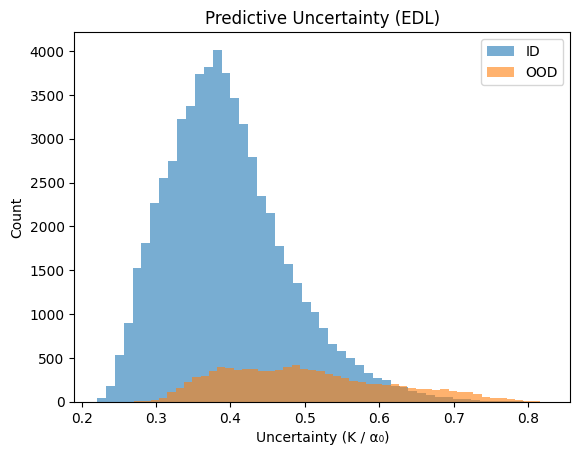

In [12]:
id_alpha0 = compute_alpha0_edl(model, train_loader, "cpu")
ood_alpha0 = compute_alpha0_edl(model, ood_loader, "cpu")

print("Mean ID α₀:", id_alpha0.mean().item())
print("Mean OOD α₀:", ood_alpha0.mean().item())


K = 10  # oder num_classes

id_unc = K / id_alpha0
ood_unc = K / ood_alpha0

import matplotlib.pyplot as plt  # noqa: E402

plt.hist(id_unc.numpy(), bins=50, alpha=0.6, label="ID")
plt.hist(ood_unc.numpy(), bins=50, alpha=0.6, label="OOD")
plt.xlabel("Uncertainty (K / α₀)")
plt.ylabel("Count")
plt.legend()
plt.title("Predictive Uncertainty (EDL)")
plt.show()